In [2]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import wordnet as wn
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings('ignore')

In [96]:
data = pd.read_csv('../Dataset/employee_reviews.csv', encoding = "ISO-8859-1",error_bad_lines=False);
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67529 entries, 0 to 67528
Data columns (total 17 columns):
Unnamed: 0                    67529 non-null int64
company                       67529 non-null object
location                      67529 non-null object
dates                         67529 non-null object
job-title                     67529 non-null object
summary                       67409 non-null object
pros                          67529 non-null object
cons                          67529 non-null object
advice-to-mgmt                67232 non-null object
overall-ratings               67529 non-null float64
work-balance-stars            67529 non-null object
culture-values-stars          67529 non-null object
carrer-opportunities-stars    67529 non-null object
comp-benefit-stars            67529 non-null object
senior-mangemnet-stars        67529 non-null object
helpful-count                 67529 non-null int64
link                          67529 non-null object
dtypes: 

Note some null values in *summary* and *advice-to-mgmt*

In [2]:
data.head()

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,1,google,none,"Dec 11, 2018",Current Employee - Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,none,5.0,4.0,5.0,5.0,4.0,5.0,0,https://www.glassdoor.com/Reviews/Google-Revie...
1,2,google,"Mountain View, CA","Jun 21, 2013",Former Employee - Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,4.0,2.0,3.0,3.0,5.0,3.0,2094,https://www.glassdoor.com/Reviews/Google-Revie...
2,3,google,"New York, NY","May 10, 2014",Current Employee - Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,5.0,4.0,5.0,5.0,4.0,949,https://www.glassdoor.com/Reviews/Google-Revie...
3,4,google,"Mountain View, CA","Feb 8, 2015",Current Employee - Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,5.0,2.0,5.0,5.0,4.0,5.0,498,https://www.glassdoor.com/Reviews/Google-Revie...
4,5,google,"Los Angeles, CA","Jul 19, 2018",Former Employee - Software Engineer,"Unique, one of a kind dream job",Google is a world of its own. At every other c...,"If you don't work in MTV (HQ), you will be giv...",Promote managers into management for their man...,5.0,5.0,5.0,5.0,5.0,5.0,49,https://www.glassdoor.com/Reviews/Google-Revie...


In [3]:
data.groupby('company').count()

,Unnamed: 0,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
company,,,,,,,,,,,,,,,,
amazon,26430,26430,26430,26430,26391,26430,26430,26318,26430,26430,26430,26430,26430,26430,26430,26430
apple,12950,12950,12950,12950,12922,12950,12950,12885,12950,12950,12950,12950,12950,12950,12950,12950
facebook,1590,1590,1590,1590,1585,1590,1590,1583,1590,1590,1590,1590,1590,1590,1590,1590
google,7819,7819,7819,7819,7804,7819,7819,7789,7819,7819,7819,7819,7819,7819,7819,7819
microsoft,17930,17930,17930,17930,17906,17930,17930,17850,17930,17930,17930,17930,17930,17930,17930,17930
netflix,810,810,810,810,801,810,810,807,810,810,810,810,810,810,810,810


In [97]:
data.summary.fillna("", inplace=True)
data['advice-to-mgmt'].fillna("", inplace=True)

In [98]:
facebook_df=data.loc[data['company']=='facebook']

In [6]:
facebook_df

,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
34249,34250,facebook,"Menlo Park, CA","Dec 11, 2018",Current Employee - Product Operations,2nd Job out of college --> Great Experience,Context: I worked in operations - Very entrepr...,- Very entrepreneurial culture: There is no fo...,none,5.0,4.0,4.0,5.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...
34250,34251,facebook,"Menlo Park, CA","Feb 16, 2017",Current Employee - Anonymous Employee,"Fast paced company with high expectations, but...",- Incredible benefits - Excellent compensation...,- If you don't learn to make the work life bal...,"Keep doing what you're doing, keep an eye on e...",5.0,5.0,5.0,5.0,5.0,5.0,294,https://www.glassdoor.com/Reviews/Facebook-Rev...
34251,34252,facebook,"Menlo Park, CA","Feb 16, 2016",Current Employee - Site Selection Program Manager,Pleasantly Surprised,I'm a 55 year old working in a company where t...,"Like any tech company, the work is big and com...",Keep doing what you're doing and fight hard to...,5.0,4.0,5.0,4.0,5.0,5.0,363,https://www.glassdoor.com/Reviews/Facebook-Rev...
34252,34253,facebook,"Menlo Park, CA","Dec 3, 2018",Current Employee - Anonymous Employee,Don't believe all of the negative press,Having worked at Facebook for a number of year...,"Particularly as of late, Facebook has been sub...",none,5.0,4.0,5.0,5.0,5.0,5.0,6,https://www.glassdoor.com/Reviews/Facebook-Rev...
34253,34254,facebook,"Seattle, WA","Dec 5, 2018",Current Employee - Staff Software Engineer,Continues to be an amazing place to be,Smart people who were chosen to be good to wor...,Took a year and a half to learn to play defens...,I'd love to see management be half as open wit...,5.0,5.0,5.0,5.0,4.0,5.0,4,https://www.glassdoor.com/Reviews/Facebook-Rev...
34254,34255,facebook,"Menlo Park, CA","Oct 19, 2018",Current Employee - Product Manager,"AVOID FB, incompetent management, bias against...","all the industry perks (food, 401k matching, s...",Itâs just awful inside FB and no one seems t...,I donât think any advice I could give you wo...,2.0,1.0,1.0,2.0,4.0,1.0,52,https://www.glassdoor.com/Reviews/Facebook-Rev...
34255,34256,facebook,"New York, NY","Nov 27, 2018",Current Employee - Anonymous Employee,Recruiting,"Incredible health insurance covered 100%, free...",Nothing that really comes to mind,Keep it up! It's so inspiring to hear from our...,5.0,5.0,5.0,5.0,5.0,5.0,3,https://www.glassdoor.com/Reviews/Facebook-Rev...
34256,34257,facebook,"Chicago, IL","Dec 6, 2018",Current Employee - Sourcer,"Not for everyone, high stress, and company gro...",World class benefits Smart coworkers Food galo...,No work life balance Unrealistic recruiting e...,Stop micromanaging your Sourcers. The current...,3.0,2.0,3.0,2.0,3.0,2.0,5,https://www.glassdoor.com/Reviews/Facebook-Rev...
34257,34258,facebook,"Menlo Park, CA","Nov 30, 2018",Current Employee - Project Manager,Loves its employees,I've never been treated this well in any job. ...,"I was about to write that we use Outlook, and ...",Keep it up! The weekly Question and Answer ses...,5.0,5.0,5.0,5.0,5.0,5.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...
34258,34259,facebook,"New York, NY","Nov 29, 2018",Current Employee - Research Scientist,Great company,Learning from great software engineers and/or ...,Too many political debates inside the company.,Create a more neutral (less political) working...,5.0,4.0,5.0,5.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...


In [99]:
facebook_df.reset_index(inplace=True)
facebook_df

,index,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,34249,34250,facebook,"Menlo Park, CA","Dec 11, 2018",Current Employee - Product Operations,2nd Job out of college --> Great Experience,Context: I worked in operations - Very entrepr...,- Very entrepreneurial culture: There is no fo...,none,5.0,4.0,4.0,5.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...
1,34250,34251,facebook,"Menlo Park, CA","Feb 16, 2017",Current Employee - Anonymous Employee,"Fast paced company with high expectations, but...",- Incredible benefits - Excellent compensation...,- If you don't learn to make the work life bal...,"Keep doing what you're doing, keep an eye on e...",5.0,5.0,5.0,5.0,5.0,5.0,294,https://www.glassdoor.com/Reviews/Facebook-Rev...
2,34251,34252,facebook,"Menlo Park, CA","Feb 16, 2016",Current Employee - Site Selection Program Manager,Pleasantly Surprised,I'm a 55 year old working in a company where t...,"Like any tech company, the work is big and com...",Keep doing what you're doing and fight hard to...,5.0,4.0,5.0,4.0,5.0,5.0,363,https://www.glassdoor.com/Reviews/Facebook-Rev...
3,34252,34253,facebook,"Menlo Park, CA","Dec 3, 2018",Current Employee - Anonymous Employee,Don't believe all of the negative press,Having worked at Facebook for a number of year...,"Particularly as of late, Facebook has been sub...",none,5.0,4.0,5.0,5.0,5.0,5.0,6,https://www.glassdoor.com/Reviews/Facebook-Rev...
4,34253,34254,facebook,"Seattle, WA","Dec 5, 2018",Current Employee - Staff Software Engineer,Continues to be an amazing place to be,Smart people who were chosen to be good to wor...,Took a year and a half to learn to play defens...,I'd love to see management be half as open wit...,5.0,5.0,5.0,5.0,4.0,5.0,4,https://www.glassdoor.com/Reviews/Facebook-Rev...
5,34254,34255,facebook,"Menlo Park, CA","Oct 19, 2018",Current Employee - Product Manager,"AVOID FB, incompetent management, bias against...","all the industry perks (food, 401k matching, s...",Itâs just awful inside FB and no one seems t...,I donât think any advice I could give you wo...,2.0,1.0,1.0,2.0,4.0,1.0,52,https://www.glassdoor.com/Reviews/Facebook-Rev...
6,34255,34256,facebook,"New York, NY","Nov 27, 2018",Current Employee - Anonymous Employee,Recruiting,"Incredible health insurance covered 100%, free...",Nothing that really comes to mind,Keep it up! It's so inspiring to hear from our...,5.0,5.0,5.0,5.0,5.0,5.0,3,https://www.glassdoor.com/Reviews/Facebook-Rev...
7,34256,34257,facebook,"Chicago, IL","Dec 6, 2018",Current Employee - Sourcer,"Not for everyone, high stress, and company gro...",World class benefits Smart coworkers Food galo...,No work life balance Unrealistic recruiting e...,Stop micromanaging your Sourcers. The current...,3.0,2.0,3.0,2.0,3.0,2.0,5,https://www.glassdoor.com/Reviews/Facebook-Rev...
8,34257,34258,facebook,"Menlo Park, CA","Nov 30, 2018",Current Employee - Project Manager,Loves its employees,I've never been treated this well in any job. ...,"I was about to write that we use Outlook, and ...",Keep it up! The weekly Question and Answer ses...,5.0,5.0,5.0,5.0,5.0,5.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...
9,34258,34259,facebook,"New York, NY","Nov 29, 2018",Current Employee - Research Scientist,Great company,Learning from great software engineers and/or ...,Too many political debates inside the company.,Create a more neutral (less political) working...,5.0,4.0,5.0,5.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...


In [8]:
facebook_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 18 columns):
index                         1590 non-null int64
Unnamed: 0                    1590 non-null int64
company                       1590 non-null object
location                      1590 non-null object
dates                         1590 non-null object
job-title                     1590 non-null object
summary                       1590 non-null object
pros                          1590 non-null object
cons                          1590 non-null object
advice-to-mgmt                1590 non-null object
overall-ratings               1590 non-null float64
work-balance-stars            1590 non-null object
culture-values-stars          1590 non-null object
carrer-opportunities-stars    1590 non-null object
comp-benefit-stars            1590 non-null object
senior-mangemnet-stars        1590 non-null object
helpful-count                 1590 non-null int64
link                        

### Preprocess data

- convert all words to lowercase
- tokenize the words
- remove numbers (but not words that contain numbers)
- remove words that have less than or equal to two characters
- remove stopwords
- lemmatize all words

No stemming of words is done for better understanding of words

In [81]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords = nltk.corpus.stopwords.words('english')
stoplist = ['facebook', 'people', 'company', 'work']
stopwords.extend(stoplist)

In [100]:
def pre_process(docs):
    doc = docs.copy(deep=True)
    for idx in range(len(docs)):
        doc[idx] = docs[idx].lower()  # Convert to lowercase.
        doc[idx] = tokenizer.tokenize(doc[idx])  # Split into words.

        # Remove numbers, but not words that contain numbers.
        doc[idx] = [token for token in doc[idx] if not token.isdigit()]
        #docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
        # Remove words that are <= two characters.
        doc[idx] = [token for token in doc[idx] if len(token) > 2]
        #docs = [[token for token in doc if len(token) > 3] for doc in docs]
        
        # Lemmatize all words in documents.
        doc[idx] = [lemmatizer.lemmatize(token) for token in doc[idx]]
        
        # Remove stopwords
        doc[idx] = [token for token in doc[idx] if token not in stopwords]
    
        #docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    
    return doc

In [101]:
all_columns = ['pros','cons','summary','advice-to-mgmt']

for col in all_columns:
    facebook_df[col] = pre_process(facebook_df[col])

In [30]:
facebook_df

,index,Unnamed: 0,company,location,dates,job-title,summary,pros,cons,advice-to-mgmt,overall-ratings,work-balance-stars,culture-values-stars,carrer-opportunities-stars,comp-benefit-stars,senior-mangemnet-stars,helpful-count,link
0,34249,34250,facebook,"Menlo Park, CA","Dec 11, 2018",Current Employee - Product Operations,"[2nd, job, college, great, experience]","[context, worked, operation, entrepreneurial, ...","[entrepreneurial, culture, formal, way, thing,...",[none],5.0,4.0,4.0,5.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...
1,34250,34251,facebook,"Menlo Park, CA","Feb 16, 2017",Current Employee - Anonymous Employee,"[fast, paced, company, high, expectation, incr...","[incredible, benefit, excellent, compensation,...","[learn, make, work, life, balance, work, exhau...","[keep, keep, eye, employee, burnout, keep, sup...",5.0,5.0,5.0,5.0,5.0,5.0,294,https://www.glassdoor.com/Reviews/Facebook-Rev...
2,34251,34252,facebook,"Menlo Park, CA","Feb 16, 2016",Current Employee - Site Selection Program Manager,"[pleasantly, surprised]","[year, old, working, company, average, age, ne...","[like, tech, company, work, big, complicated, ...","[keep, fight, hard, complacent, believe, humil...",5.0,4.0,5.0,4.0,5.0,5.0,363,https://www.glassdoor.com/Reviews/Facebook-Rev...
3,34252,34253,facebook,"Menlo Park, CA","Dec 3, 2018",Current Employee - Anonymous Employee,"[believe, negative, press]","[worked, number, year, experienced, many, comp...","[particularly, late, subject, lot, negative, p...",[none],5.0,4.0,5.0,5.0,5.0,5.0,6,https://www.glassdoor.com/Reviews/Facebook-Rev...
4,34253,34254,facebook,"Seattle, WA","Dec 5, 2018",Current Employee - Staff Software Engineer,"[continues, amazing, place]","[smart, people, chosen, good, work, empathic, ...","[took, year, half, learn, play, defense, work,...","[love, see, management, half, open, press, emp...",5.0,5.0,5.0,5.0,4.0,5.0,4,https://www.glassdoor.com/Reviews/Facebook-Rev...
5,34254,34255,facebook,"Menlo Park, CA","Oct 19, 2018",Current Employee - Product Manager,"[avoid, incompetent, management, bias, woman]","[industry, perk, food, 401k, matching, shuttle...","[itâ, awful, inside, one, seems, talking, comp...","[donâ, think, advice, could, give, would, help...",2.0,1.0,1.0,2.0,4.0,1.0,52,https://www.glassdoor.com/Reviews/Facebook-Rev...
6,34255,34256,facebook,"New York, NY","Nov 27, 2018",Current Employee - Anonymous Employee,[recruiting],"[incredible, health, insurance, covered, free,...","[nothing, really, come, mind]","[keep, inspiring, hear, leadership, team, week...",5.0,5.0,5.0,5.0,5.0,5.0,3,https://www.glassdoor.com/Reviews/Facebook-Rev...
7,34256,34257,facebook,"Chicago, IL","Dec 6, 2018",Current Employee - Sourcer,"[everyone, high, stress, company, growing, pain]","[world, class, benefit, smart, coworkers, food...","[work, life, balance, unrealistic, recruiting,...","[stop, micromanaging, sourcers, current, recru...",3.0,2.0,3.0,2.0,3.0,2.0,5,https://www.glassdoor.com/Reviews/Facebook-Rev...
8,34257,34258,facebook,"Menlo Park, CA","Nov 30, 2018",Current Employee - Project Manager,"[love, employee]","[never, treated, well, job, honestly, love, em...","[write, use, outlook, gsuite, con, today, mark...","[keep, weekly, question, answer, session, real...",5.0,5.0,5.0,5.0,5.0,5.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...
9,34258,34259,facebook,"New York, NY","Nov 29, 2018",Current Employee - Research Scientist,"[great, company]","[learning, great, software, engineer, researcher]","[many, political, debate, inside, company]","[create, neutral, le, political, working, envi...",5.0,4.0,5.0,5.0,5.0,4.0,0,https://www.glassdoor.com/Reviews/Facebook-Rev...


In [31]:
facebook_df['pros'].values

array([list(['context', 'worked', 'operation', 'entrepreneurial', 'culture', 'encouraged', 'build', 'system', 'process', 'accomplish', 'need', 'perk', 'great', 'collaborative', 'environment', 'giving', 'receiving', 'honest', 'constructive', 'feedback', 'huge', 'part', 'culture', 'lot', 'room', 'growth', 'career', 'conversation', 'encouraged']),
       list(['incredible', 'benefit', 'excellent', 'compensation', 'reward', 'strong', 'performance', 'lot', 'autonomy', 'ton', 'room', 'growth', 'transparent', 'top', 'strong', 'leadership', 'intelligent', 'caring', 'colleague', 'fair', 'well', 'thought', 'review', 'process', 'find', 'everywhere', 'exciting', 'work']),
       list(['year', 'old', 'working', 'company', 'average', 'age', 'never', 'happier', 'always', 'wanted', 'work', 'company', 'proverbial', 'square', 'peg', 'nearly', 'year', 'work', 'force', 'believe', 'found', 'company', 'complement', 'ideology', 'company', 'operate', 'pro', 'see', 'leadership', 'mark', 'zuckerberg', 'sheryl',

### LDA on Facebook's pros

In [102]:
pro_dictionary = corpora.Dictionary(facebook_df['pros'].values)
#dictionary = gensim.corpora.Dictionary(documents=data.processed.values)
print("Found {} words.".format(len(pro_dictionary.values())))
#amazon_corpus = [amazon_pro_dictionary.doc2bow(text) for text in amazon_sentences]

Found 3657 words.


In [80]:
pro_dictionary.token2id

{'accomplish': 0,
 'build': 1,
 'career': 2,
 'collaborative': 3,
 'constructive': 4,
 'context': 5,
 'conversation': 6,
 'culture': 7,
 'encouraged': 8,
 'entrepreneurial': 9,
 'environment': 10,
 'feedback': 11,
 'giving': 12,
 'great': 13,
 'growth': 14,
 'honest': 15,
 'huge': 16,
 'lot': 17,
 'need': 18,
 'operation': 19,
 'part': 20,
 'perk': 21,
 'process': 22,
 'receiving': 23,
 'room': 24,
 'system': 25,
 'worked': 26,
 'autonomy': 27,
 'benefit': 28,
 'caring': 29,
 'colleague': 30,
 'compensation': 31,
 'everywhere': 32,
 'excellent': 33,
 'exciting': 34,
 'fair': 35,
 'find': 36,
 'incredible': 37,
 'intelligent': 38,
 'leadership': 39,
 'performance': 40,
 'review': 41,
 'reward': 42,
 'strong': 43,
 'thought': 44,
 'ton': 45,
 'top': 46,
 'transparent': 47,
 'well': 48,
 'work': 49,
 'age': 50,
 'ago': 51,
 'always': 52,
 'average': 53,
 'believe': 54,
 'better': 55,
 'building': 56,
 'chris': 57,
 'clearly': 58,
 'coming': 59,
 'company': 60,
 'complement': 61,
 'connect

In [103]:
pro_corpus = [pro_dictionary.doc2bow(doc) for doc in facebook_df['pros']]

In [116]:
def compute_coherence_values(dictionary, corpus,limit, start=2, step=3):
    """Function to calculate the coherence for each model with varying number of topics to find the optimal 
    number of topics for the LDA Model"""
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, 
                                              chunksize=200, passes=2)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [117]:
model_list, coherence_values = compute_coherence_values(dictionary=pro_dictionary, corpus=pro_corpus, start=2, limit=50, step=2)

#Save the model so we won't have to run the function again

filename = 'facebook_pro_coherence_models'
outfile = open(filename,'wb')
pickle.dump(model_list,outfile)
outfile.close()

filename = 'facebook_pro_coherence_val'
outfile = open(filename,'wb')
pickle.dump(coherence_values,outfile)
outfile.close()

In [118]:
# to open the files and retrieve model_list and coh_vals
pickle_in = open("facebook_pro_coherence_models","rb")
pro_model_list = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("facebook_pro_coherence_val", "rb")
pro_coh_val = pickle.load(pickle_in)
pickle_in.close()

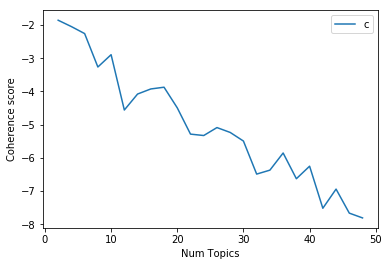

In [119]:
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, pro_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [120]:
print(pro_coh_val)

[-1.8543828392597157, -2.0457017737979735, -2.2563405026483627, -3.2633206242248325, -2.8920798540527803, -4.5592405243542995, -4.07815158440075, -3.9248635853598843, -3.87245450986453, -4.494007123099321, -5.285767732725888, -5.3280539397367965, -5.088503963217784, -5.235369000985356, -5.494508589192313, -6.49015039847895, -6.371344431601108, -5.854725168403584, -6.629967953969135, -6.252110019024094, -7.519512433918141, -6.94250399694348, -7.666554185384678, -7.810787239156009]


In [151]:
pro_model_list[0].print_topics(num_words=5)

[(0,
  '0.021*"great" + 0.016*"culture" + 0.012*"impact" + 0.011*"fast" + 0.011*"amazing"'),
 (1,
  '0.020*"great" + 0.019*"good" + 0.017*"food" + 0.015*"lot" + 0.013*"perk"')]

### LDA on Facebook's cons

In [124]:
con_dictionary = corpora.Dictionary(facebook_df['cons'].values)

print("Found {} words.".format(len(con_dictionary.values())))

Found 4109 words.


In [125]:
con_corpus = [con_dictionary.doc2bow(doc) for doc in facebook_df['cons']]

In [126]:
model_list, coherence_values = compute_coherence_values(dictionary=con_dictionary, corpus=con_corpus, start=2, limit=50, step=2)

#Save the model so we won't have to run the function again

import pickle
filename = 'facebook_con_coherence_models'
outfile = open(filename,'wb')
pickle.dump(model_list,outfile)
outfile.close()

filename = 'facebook_con_coherence_val'
outfile = open(filename,'wb')
pickle.dump(coherence_values,outfile)
outfile.close()

In [127]:
pickle_in = open("facebook_con_coherence_models","rb")
con_model_list = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("facebook_con_coherence_val", "rb")
con_coh_val = pickle.load(pickle_in)
pickle_in.close()

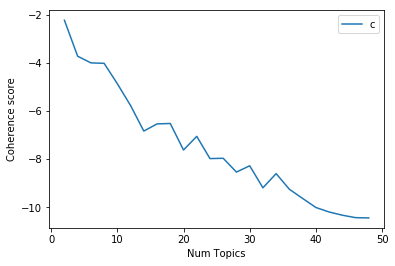

In [128]:
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, con_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [129]:
print(con_coh_val)

[-2.2360639722278153, -3.729446183600394, -4.006081339370089, -4.025076780721184, -4.872409470559686, -5.778443209552339, -6.837890078813984, -6.5403422887958556, -6.523097514896243, -7.62406389403579, -7.057596011913578, -7.980422867624774, -7.967428952916943, -8.540652478796218, -8.278944861462914, -9.192923729848072, -8.604598020728737, -9.254579267518952, -9.634712737681625, -10.010325087055339, -10.197600064027503, -10.330986808789818, -10.432705050749524, -10.443715575582923]


In [157]:
con_model_list[0].print_topics(num_words=5)

[(0,
  '0.010*"manager" + 0.009*"good" + 0.009*"team" + 0.009*"employee" + 0.008*"make"'),
 (1,
  '0.015*"life" + 0.012*"balance" + 0.011*"get" + 0.011*"time" + 0.011*"sometimes"')]

In [158]:
con_model_list[1].print_topics(num_words=5)

[(0,
  '0.032*"con" + 0.018*"think" + 0.010*"one" + 0.009*"nothing" + 0.009*"really"'),
 (1,
  '0.026*"life" + 0.021*"hour" + 0.021*"balance" + 0.017*"office" + 0.014*"working"'),
 (2,
  '0.010*"job" + 0.009*"wa" + 0.008*"feel" + 0.008*"manager" + 0.008*"salary"'),
 (3,
  '0.017*"get" + 0.013*"sometimes" + 0.012*"time" + 0.012*"lot" + 0.011*"fast"')]

### LDA on Facebook's summary

In [132]:
sum_dictionary = corpora.Dictionary(facebook_df['summary'].values)

print("Found {} words.".format(len(sum_dictionary.values())))

Found 1077 words.


Since there are very few words, we do not filter them further.

In [133]:
sum_corpus = [sum_dictionary.doc2bow(doc) for doc in facebook_df['summary']]

In [134]:
model_list, coherence_values = compute_coherence_values(dictionary=sum_dictionary, corpus=sum_corpus, start=2, limit=50, step=2)

#Save the model so we won't have to run the function again

import pickle
filename = 'facebook_sum_coherence_models'
outfile = open(filename,'wb')
pickle.dump(model_list,outfile)
outfile.close()

filename = 'facebook_sum_coherence_val'
outfile = open(filename,'wb')
pickle.dump(coherence_values,outfile)
outfile.close()

In [135]:
pickle_in = open("facebook_sum_coherence_models","rb")
sum_model_list = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("facebook_sum_coherence_val", "rb")
sum_coh_val = pickle.load(pickle_in)
pickle_in.close()

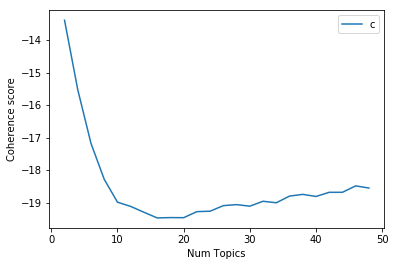

In [136]:
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, sum_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [137]:
print(sum_coh_val)

[-13.389461841787192, -15.52843447211157, -17.178943293694143, -18.283602208386846, -18.985903990614933, -19.116190936021336, -19.296136714958482, -19.46999990589306, -19.459976343434498, -19.463123365869734, -19.277241054662543, -19.263406100854557, -19.092041235900826, -19.060974521598297, -19.108375443632667, -18.95788144449216, -19.00408485342016, -18.798990600515353, -18.745721854621742, -18.81044555214469, -18.682460409075407, -18.68193172909309, -18.484303508026645, -18.550712982827438]


In [153]:
sum_model_list[0].print_topics(num_words=5)

[(0,
  '0.108*"place" + 0.089*"great" + 0.065*"best" + 0.048*"amazing" + 0.028*"awesome"'),
 (1,
  '0.025*"culture" + 0.024*"engineer" + 0.023*"experience" + 0.020*"good" + 0.017*"working"')]

### LDA on Facebook's advice-to-mgmt

In [140]:
adv_dictionary = corpora.Dictionary(facebook_df['advice-to-mgmt'].values)

print("Found {} words.".format(len(adv_dictionary.values())))

Found 2203 words.


In [141]:
adv_corpus = [adv_dictionary.doc2bow(doc) for doc in facebook_df['advice-to-mgmt']]

In [142]:
model_list, coherence_values = compute_coherence_values(dictionary=adv_dictionary, corpus=adv_corpus, start=2, limit=50, step=2)

#Save the model so we won't have to run the function again

import pickle
filename = 'facebook_adv_coherence_models'
outfile = open(filename,'wb')
pickle.dump(model_list,outfile)
outfile.close()

filename = 'facebook_adv_coherence_val'
outfile = open(filename,'wb')
pickle.dump(coherence_values,outfile)
outfile.close()

In [143]:
pickle_in = open("facebook_adv_coherence_models","rb")
adv_model_list = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("facebook_adv_coherence_val", "rb")
adv_coh_val = pickle.load(pickle_in)
pickle_in.close()

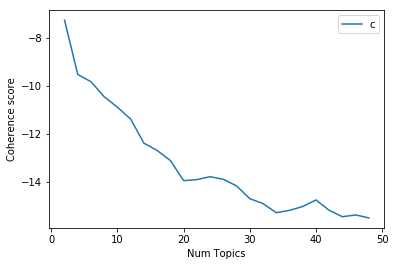

In [144]:
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, adv_coh_val)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [145]:
print(adv_coh_val)

[-7.266061205016337, -9.526739991433136, -9.829965547200569, -10.456515113017652, -10.892603113817, -11.389446125042832, -12.391779781940842, -12.696167839601607, -13.116967033361796, -13.953275822257476, -13.910581816113522, -13.789849166062426, -13.896589064990396, -14.173053094857062, -14.705219894463852, -14.910583366098887, -15.289798634768692, -15.19148556912993, -15.031272575180227, -14.758143907592189, -15.190910889641893, -15.457624429893485, -15.38307905055999, -15.5073386652464]


In [154]:
adv_model_list[0].print_topics(num_words=5)

[(0,
  '0.161*"none" + 0.065*"keep" + 0.015*"great" + 0.015*"continue" + 0.012*"culture"'),
 (1,
  '0.014*"employee" + 0.013*"manager" + 0.011*"good" + 0.011*"team" + 0.010*"make"')]